### Baseline model

In [2]:
import time as time
import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('trajectory_dec_2019_rev.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print('Finished reading {} records'.format(len(df)))

Finished reading 3851694 records


In [6]:
df.head()

,time,mmsi,speed,accuracy,course,turn,status,shiptype,lon,lat
0,2019-12-01 00:00:07,563037440,0.2,0.0,94.3,-128.0,15.0,89.0,103.76168,1.29001
1,2019-12-01 00:00:30,255805665,16.8,0.0,46.1,0.0,0.0,Undefined,103.75723,1.13256
2,2019-12-01 00:00:30,563009650,2.1,1.0,130.3,-128.0,0.0,31.0,103.63240,1.20683
3,2019-12-01 00:00:53,563042100,4.5,0.0,288.4,4.0,0.0,80.0,103.73411,1.29129
4,2019-12-01 00:00:53,563003860,0.2,1.0,296.7,-128.0,0.0,Undefined,103.76037,1.29499


Check null values

In [8]:
df.isnull().sum()

time        0
mmsi        0
speed       0
accuracy    0
course      0
turn        0
status      0
shiptype    0
lon         0
lat         0
dtype: int64

In [9]:
dataset = df[['mmsi', 'speed', 'course', 'turn', 'lon', 'lat']]
dataset.index = df['time']

In [11]:
dataset.head()

,mmsi,speed,course,turn,lon,lat
time,,,,,,
2019-12-01 00:00:07,563037440,0.2,94.3,-128.0,103.76168,1.29001
2019-12-01 00:00:30,255805665,16.8,46.1,0.0,103.75723,1.13256
2019-12-01 00:00:30,563009650,2.1,130.3,-128.0,103.63240,1.20683
2019-12-01 00:00:53,563042100,4.5,288.4,4.0,103.73411,1.29129
2019-12-01 00:00:53,563003860,0.2,296.7,-128.0,103.76037,1.29499


Group dataset by MMSI

In [12]:
def sortByMmsi(df):
    val = df['mmsi'].value_counts().tolist()
    idx = df['mmsi'].value_counts().index.tolist()
    val_idx = dict(zip(idx, val))

    frames = []
    for mmsi, length in val_idx.items():
        dfn = df[df['mmsi']==mmsi]
        frames.append(dfn)
    df_sort = pd.concat(frames)
    return df_sort

In [14]:
dataset_group = sortByMmsi(dataset)

In [15]:
dataset_group.head()

,mmsi,speed,course,turn,lon,lat
time,,,,,,
2019-12-01 00:09:01,563032960,0.0,148.4,-128.0,103.75320,1.29052
2019-12-01 00:15:11,563032960,0.0,148.4,-128.0,103.75320,1.29044
2019-12-01 00:19:02,563032960,0.0,148.4,-128.0,103.75323,1.29044
2019-12-01 00:21:50,563032960,0.0,148.4,-128.0,103.75323,1.29046
2019-12-01 00:27:43,563032960,0.1,148.4,-128.0,103.75324,1.29040


In [36]:
dataset_group = dataset_group.loc[(((dataset_group['lon'] > 103.33) & (dataset_group['lon'] < 104.30)) &
                             ((dataset_group['lat'] > 0.97) & (dataset_group['lat'] < 1.47)))]

In [67]:
print('data after filtered to Singapore Straits region {} records, or removed {:.4f}% records'.format(len(dataset_group), (len(df)-len(dataset_group))/len(df)))

data after filtered to Singapore Straits region 3843301 records, or removed 0.0022% records


Distribution of speed

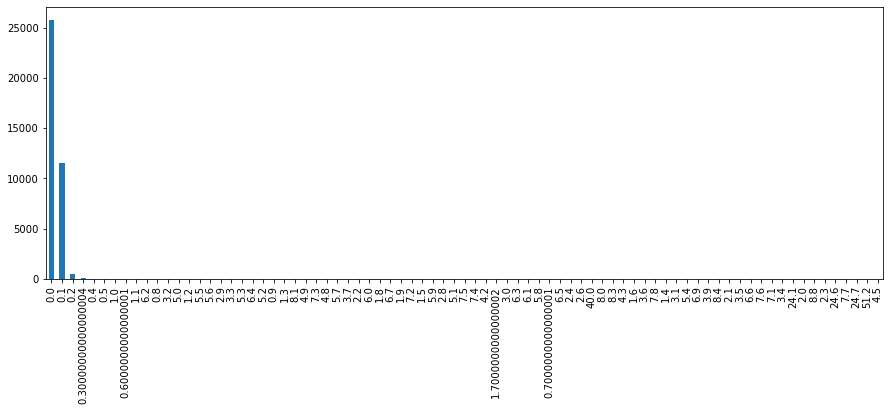

In [37]:
dataset_group.loc[dataset_group['mmsi'] == 563032960]['speed'].value_counts().plot(kind='bar', figsize=(15,5))

In [47]:
data_lon = dataset_group['lon']
data_lat = dataset_group['lat']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11dd6a3d0>],
      dtype=object)

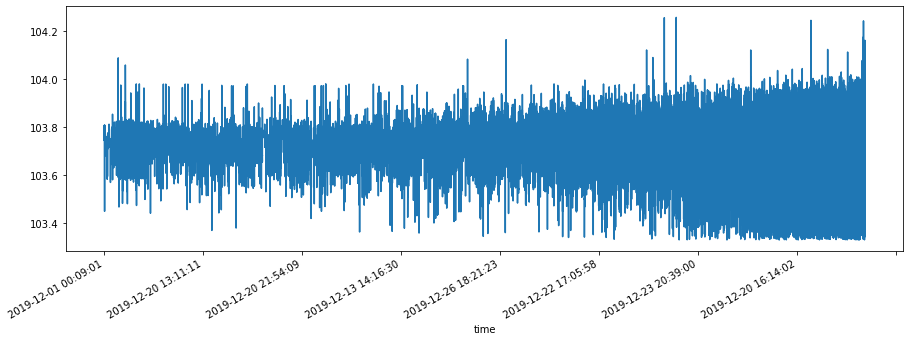

In [50]:
data_lon.plot(subplots=True, figsize=(15,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e042c10>],
      dtype=object)

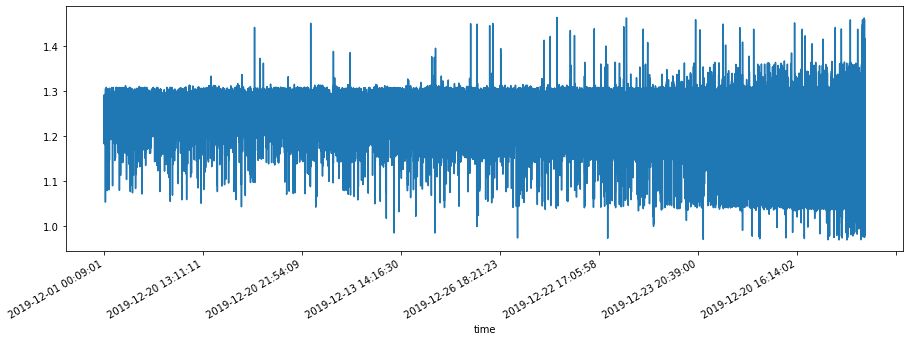

In [51]:
data_lat.plot(subplots=True, figsize=(15,5))

(array([7.74100e+03, 4.37410e+04, 2.60249e+05, 9.53620e+05, 2.26459e+06,
        3.02421e+05, 1.08140e+04, 1.09000e+02, 1.10000e+01, 5.00000e+00]),
 array([103.33002, 103.42266, 103.5153 , 103.60794, 103.70058, 103.79322,
        103.88586, 103.9785 , 104.07114, 104.16378, 104.25642]),
 <a list of 10 Patch objects>)

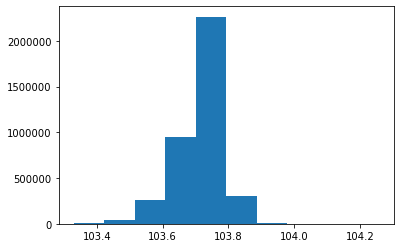

In [46]:
plt.hist(data_lon.values)

(array([3.350000e+02, 2.133900e+04, 5.828700e+04, 1.861860e+05,
        6.456160e+05, 1.245311e+06, 1.682634e+06, 3.472000e+03,
        3.100000e+01, 9.000000e+01]),
 array([0.97003 , 1.019366, 1.068702, 1.118038, 1.167374, 1.21671 ,
        1.266046, 1.315382, 1.364718, 1.414054, 1.46339 ]),
 <a list of 10 Patch objects>)

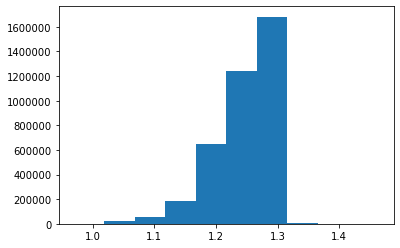

In [68]:
plt.hist(data_lat.values)

Baseline model is very simple. Prediction value is current value shifted by 1

In [99]:
first_lon = dataset_group.loc[dataset_group['mmsi'] == 563032960]['lon']
first_lat = dataset_group.loc[dataset_group['mmsi'] == 563032960]['lat']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e0fb510>],
      dtype=object)

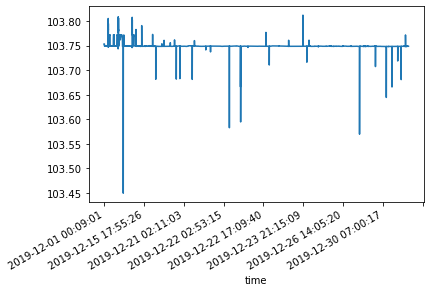

In [70]:
first_lon.plot(subplots=True)

In [85]:
def plot(x, y):
    fig, ax = plt.subplots(figsize=(20,5))
    tidx = np.arange(len(x))
    plt.plot(tidx, y)
    plt.xlabel('time')
    plt.ylabel('y')
    plt.show()

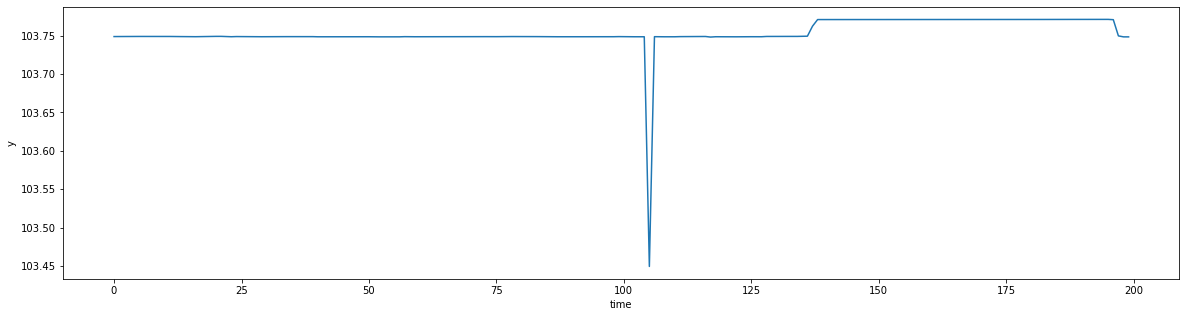

In [97]:
plot(first_lon.index[2300:2500], first_lon.values[2300:2500])

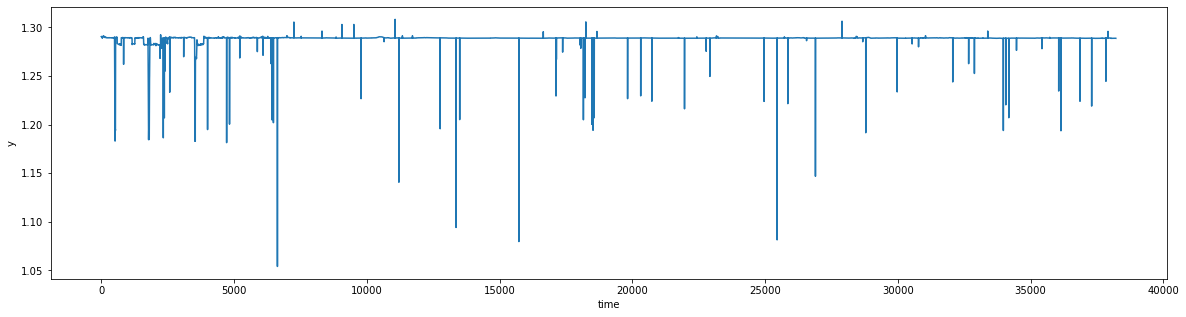

In [101]:
plot(first_lat.index, first_lat.values)

In [142]:
first_lon.values

array([103.7532 , 103.7532 , 103.75323, ..., 103.74839, 103.74839,
       103.74839])

In [186]:
bl_y = pd.DataFrame(first_lon.values)
bl_y_pred = bl_y.shift(periods=1)

bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
bl_error = np.sum(np.power(bl_residuals,2))
print('RMSE = %.5f' % bl_rmse)
# print('Lenth = %d' % len(bl_residuals))
# print('Error = %.5f' % bl_error)
# print('Error mean = %.5f' % (np.sqrt(bl_error / len(bl_residuals))))

RMSE = 0.00353


In [212]:
np.sum(np.absolute(bl_residuals / bl_y))

0    0.048642
dtype: float64

In [213]:
def error_sum(data, shift = 1):
    bl_trainset = cp.deepcopy(data)

    bl_y = pd.DataFrame(bl_trainset.values)
    bl_y_pred = bl_y.shift(periods=shift)

    bl_residuals = bl_y_pred - bl_y
    sq_error = np.sum(np.power(bl_residuals,2))
    abs_error = np.sum(np.absolute(bl_residuals))
    abs_percent_error = np.sum(np.absolute(bl_residuals / bl_y))

    return abs_error, sq_error, abs_percent_error, len(bl_residuals)

In [214]:
def plot_compare(act, pred, start, end):
    t = tidx = np.arange(len(act))
    fig, ax = plt.subplots(figsize=(10,4))
    plt.plot(t[start:end], act[start:end], 'b', label='Actual')
    plt.plot(t[start:end], pred[start:end], 'r', label='Predict')
    plt.xlabel('Time')
    plt.ylabel('Longitude')
    plt.legend()
    plt.show()

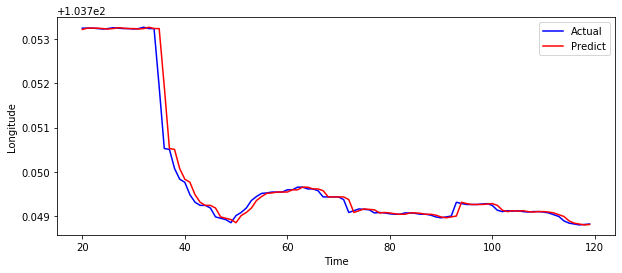

In [215]:
plot_compare(bl_y, bl_y_pred, 20, 120)

In [124]:
len(dataset_group['mmsi'].unique())

21277

In [200]:
dataset_group['mmsi'].value_counts()

563032960    38211
563069220    32673
563036620    32579
563029960    32096
563021060    30219
             ...  
477201105        1
636027329        1
353535784        1
564302003        1
566025144        1
Name: mmsi, Length: 21277, dtype: int64

In [201]:
dataset_group = dataset_group.groupby('mmsi').filter(lambda x: len(x)>30)

In [223]:
len(dataset_group['mmsi'].unique())

3687

In [225]:
dataset_group['mmsi'].value_counts()

563032960    38211
563069220    32673
563036620    32579
563029960    32096
563021060    30219
             ...  
352542000       31
229009000       31
477001600       31
538005178       31
636017533       31
Name: mmsi, Length: 3687, dtype: int64

Total datasets

In [226]:
def get_error(shift):
    total_len = 0
    total_abs_error = 0
    total_sq_error = 0
    total_abs_percent_error = 0

    for mmsi in dataset_group['mmsi'].unique():
        data_lon = dataset_group.loc[dataset_group['mmsi'] == mmsi]['lon']
        data_lat = dataset_group.loc[dataset_group['mmsi'] == mmsi]['lat']
        mae_lon, rmse_lon, mape_lon, lon_len = error_sum(data_lon, shift)
        mae_lat, rmse_lat, mape_lat, lat_len = error_sum(data_lat, shift)
        total_len += (lon_len + lat_len)
        total_abs_error += (mae_lon + mae_lat)
        total_sq_error += (rmse_lon + rmse_lat)
        total_abs_percent_error += (mape_lon + mape_lat)

    total_mae = total_abs_error / total_len
    total_mape = total_abs_percent_error / total_len
    total_rmse = np.sqrt(total_sq_error / total_len)

    print('RMSE = %.5f' % total_rmse)
    print('MAE = %.5f' % total_mae)
    print('MAPE = %.5f' % total_mape)

In [227]:
print('===Window 1===')
get_error(1)
print('===Window 10===')
get_error(10)
print('===Window 20===')
get_error(20)
print('===Window 30===')
get_error(30)

===Window 1===
RMSE = 0.00811
MAE = 0.00136
MAPE = 0.00051
===Window 10===
RMSE = 0.02143
MAE = 0.00679
MAPE = 0.00235
===Window 20===
RMSE = 0.02710
MAE = 0.00986
MAPE = 0.00336
===Window 30===
RMSE = 0.02991
MAE = 0.01174
MAPE = 0.00399


array([563032960, 563069220, 563036620, ..., 566848971, 212974288,
       538005040])